# **Connect to GDRIVE**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/My Drive/skripsiku/Data/split_data'

test  train  val


# **Import Library**

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tqdm import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

# **Inisiasi Direktori (Split Data)**

In [5]:
train_dir = '/content/drive/My Drive/skripsiku/Data/split_data/train'
val_dir = '/content/drive/My Drive/skripsiku/Data/split_data/val'
test_dir = '/content/drive/My Drive/skripsiku/Data/split_data/test'

# **Data Preparation**

In [6]:
# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
# Validasi dan test hanya dilakukan rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk validasi
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 560 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


# **Show Data Augmentasi**

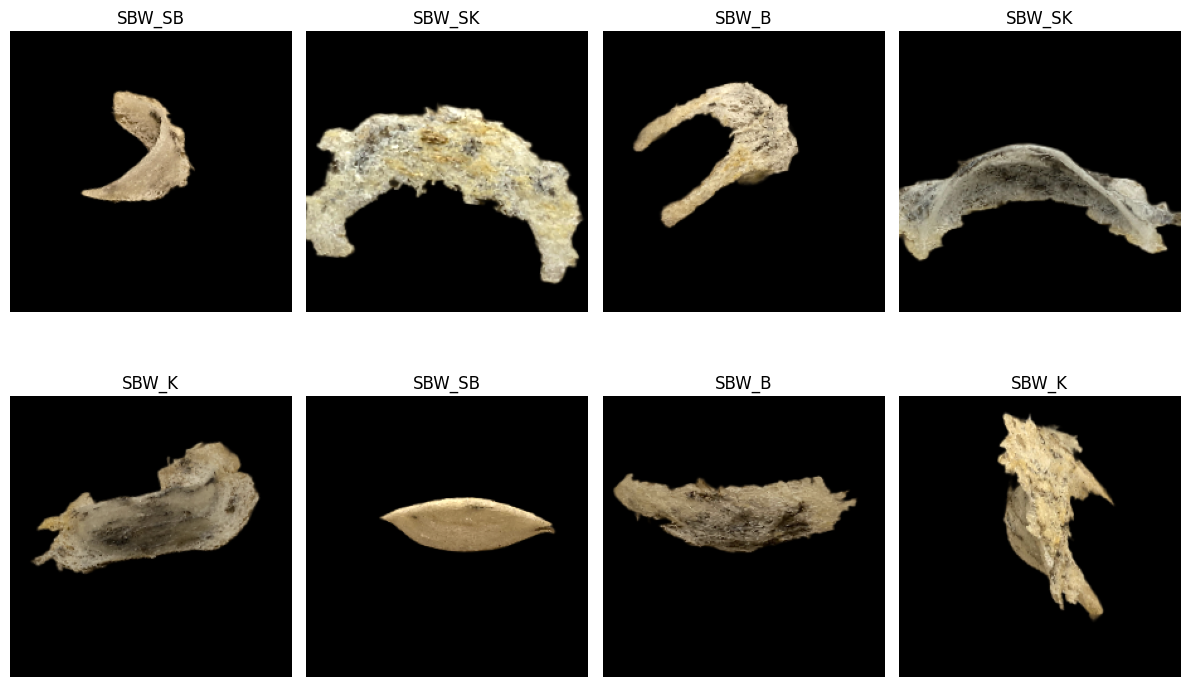

In [8]:
# Ambil satu batch dari train_generator
images, labels = next(train_generator)  # ambil batch pertama

# Ambil mapping kelas dari generator
class_indices = train_generator.class_indices
categories = list(class_indices.keys())  # urutannya sama dengan label output

# Tampilkan 8 gambar pertama
plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(categories[label_idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
class StopWhenLossBelow(Callback):
    def __init__(self, threshold=0.10):
        super(StopWhenLossBelow, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        if loss is not None and val_loss is not None:
            if loss < self.threshold and val_loss < self.threshold:
                print(f"\nLoss ({loss:.4f}) dan Val Loss ({val_loss:.4f}) di bawah {self.threshold}. Training dihentikan.")
                self.model.stop_training = True


In [12]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [13]:
stop_loss_callback = StopWhenLossBelow(threshold=0.10)

In [1]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, stop_loss_callback]
)

NameError: name 'model' is not defined